### Importin Libraries

In [1]:
import os
import cv2
import numpy as np
import imageio as iio
from matplotlib import pyplot as plt
from scipy.ndimage import gaussian_filter

#### Reading image and get the hsv version to feed the algorithm 

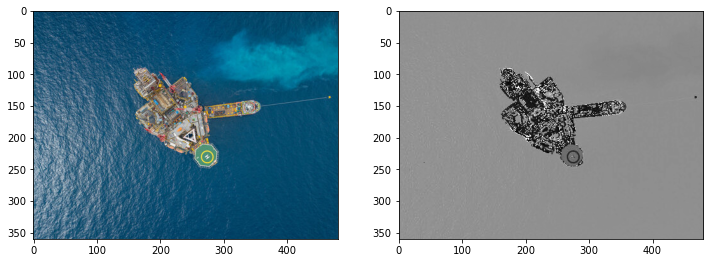

In [2]:
img = iio.imread("im04.jpg")
img_new = cv2.cvtColor(img,cv2.COLOR_RGB2HSV)

def scale(img):
    return (img-np.min(img))/(np.max(img)-np.min(img))*255

plt.figure(figsize=(12,10))
plt.subplot(1,2,1)
plt.imshow(img);
plt.subplot(1,2,2)
plt.imshow(img_new[:,:,0].astype('uint8'),cmap='gray');

#### set N=20 points from xmin,max, ymin,max

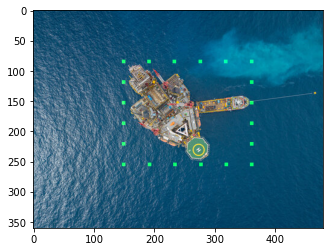

In [3]:
N = 20
points = [(0, 0)]*20
img_points = img.copy()
xmin = 85 #85
ymin = 150 #150
xmax = 255 #255
ymax = 362 #362
for i in range(N//4):
    x1 = xmin
    y1 = ymin+int((ymax-ymin)*(i/N*4))
    x2 = xmin+int((xmax-xmin)*(i/N*4))
    y2 = ymax
    x3 = xmax
    y3 = ymax-int((ymax-ymin)*(i/N*4))
    x4 = xmax-int((xmax-xmin)*(i/N*4))
    y4 = ymin
    img_points[x1-3:x1+3,y1-3:y1+3,1] = 255
    img_points[x2-3:x2+3,y2-3:y2+3,1] = 255
    img_points[x3-3:x3+3,y3-3:y3+3,1] = 255
    img_points[x4-3:x4+3,y4-3:y4+3,1] = 255
    points[i] = (x1,y1)
    points[N//4+i] = (x2,y2)
    points[2*N//4+i] = (x3,y3)
    points[3*N//4+i] = (x4,y4)
plt.imshow(img_points);
#print(points)

#### Cost calculation for given image and points, alpha , gama

In [4]:
def get_cost(img,points,gama=100,alpha=1800):
    np_points = np.array(points.copy())
    shifted_points = np.roll(np_points,1,axis=0)
    d = np.mean(np.sqrt(np.sum((np_points-shifted_points)**2,axis=1))) #d_mean
    
    E_inter = np.sum(((points-shifted_points)[:,0]**2+(points-shifted_points)[:,1]**2-alpha*d)**2)
    
    E_exter = 0
    #gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = img[:,:,0] #hue of hsv image given
    #gray = gaussian_filter(gray, sigma=10)
    grad_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, 0)
    grad_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, 0)
    for i in range(len(points)):
        #print("##",grad_x[points[i]],grad_y[points[i]])
        E_exter -= (grad_x[points[i]]**2+grad_y[points[i]]**2)
    #print(E_inter)
    #print(E_exter)
    return E_inter+gama*E_exter

#get_cost(img,points)

#### calculate contors for 120 itr and for each of N=20 points and each (3x3) neighbor,
#### and set points to which makes the cost lower and update points, 
#### for each iteration points ploted on a final image and saved in images directory,
#### in the end gama = 2e11, alpha=1.2e7 worked pretty well, you should know that by increasing gama contor gets bigger and by lowering alpha it gets bigger too.
#### by os command final video generated

In [5]:
def set_contours(img, points, gama=2e11, alpha=1.2e7):
    for i in range(120): #120 iteration
        for j in range(N): #20 points
            cost = 10**25
            x = points[j][0]
            y = points[j][1]
            neigbors = [(x-1,y),(x+1,y),(x-1,y-1),(x-1,y+1),(x,y+1),(x,y-1),(x+1,y-1),(x+1,y+1)]
            for neig in neigbors: #all 8 neigbor
                points_new = points.copy()
                points_new[j] = neig # move the point to one of it's neigbors
                cost_new = get_cost(img,points_new,gama=gama,alpha=alpha) #calculate new cost
                if cost_new<cost : #updete if cost is lower than before
                    cost = cost_new
                    points = points_new.copy()
        path = f'images/{i}.png'
        final = cv2.cvtColor(img,cv2.COLOR_HSV2RGB) #the final contor on image
        for i in range(N): #draw points
            x = points[i][0]
            y = points[i][1]
            final[x-3:x+3,y-3:y+3,1] = 255
        iio.imwrite(path,final) #write image in images directory
        
set_contours(img_new, points, gama=2e11, alpha = 1.2e7)
os.system('ffmpeg -start_number 0 -i images/%d.png -r 120 -vcodec mpeg4 res13-contour.mp4') #generate video

256